# 1-D Heat Equation

https://ocw.mit.edu/courses/mathematics/18-303-linear-partial-differential-equations-fall-2006/lecture-notes/heateqni.pdf

$\frac{\partial u}{\partial t} = \kappa \frac{\partial^2 u}{\partial x^2}$

$\kappa = K_0/c\rho$

$\hat{x}=x/L_*$

$\hat{t}=t/T_*$

$\hat{u}(\hat{x},\hat{t})=u(x,t)/U_*$

$\frac{\partial \hat{u}}{\partial \hat{t}} = \frac{T_* \kappa}{L^2_*} \frac{\partial^2 \hat{u}}{\partial \hat{x}^2}$

$T_* = L^2_*/ \kappa$

$\frac{\partial \hat{u}}{\partial \hat{t}} = \frac{\partial^2 \hat{u}}{\partial \hat{x}^2}$

Suppose the initial temperature distibution in a 1D rod is constant i.e. $f(x) = u_0$

$u(x,t) = \sum ^\inf _{n=1} B_n sin(n\pi x)e^{-n^2 \pi^2 t}$

$B_n = 2u_0 \int_0^1 sin(n \pi x) dx$

$u(x,t) = \frac{4u_0}{\pi} \sum_{n=1}^{\inf} \frac{sin((2n-1)\pi x)}{(2n-1)} e^{-(2n-1)^2\pi^2 t}$

$u(x,t) = \frac{4u_0}{\pi}\left( sin(\pi x)e^{-\pi^2 t} + \frac{sin(3\pi x)}{3}e^{-9\pi ^2 t} + ... \right)$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def approx_sol(u0, x, t, N):
    out = 0
    for i in range(N):
        n = i+1
        out += np.sin((2*n-1)*np.pi*x) * np.exp(-(2*n-1)**2 * np.pi**2 * t) / (2*n-1)
    return (4*u0/np.pi)*out

0.4683462754504995 0.9998881791315828


<function matplotlib.pyplot.show(*args, **kw)>

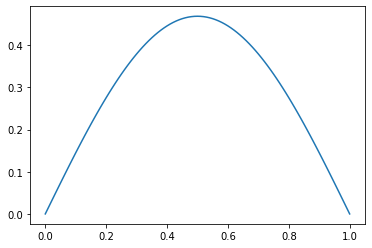

In [4]:
u0 = 1.0
x = np.linspace(0, 1, 101)
plt.figure()
for t in [1/np.pi**2]:
    sol = approx_sol(u0, x, t, N=10000)
    plt.plot(x, sol)
    print(sol.max(), sol.max()*(np.pi * np.e / 4))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

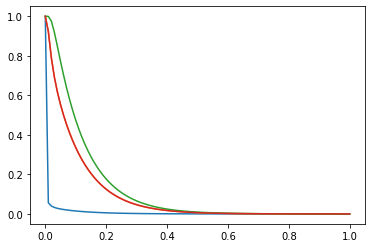

In [5]:
t = np.linspace(0, 1, 101)
plt.figure()
for x in [0.01, 0.25, 0.5, 0.75]:
    plt.plot(t, approx_sol(u0, x, t, N=10000))
plt.show

In [6]:
# Copper
K0 = 400
rho = 8960
Cp = 385
kappa = K0/(rho*Cp)
print(kappa)
l = 1.0

0.00011595547309833024


In [7]:
def approx_sol_dim(u0, x, t, N, kappa, l):
    out = 0
    for i in range(N):
        n = i+1
        out += np.sin((2*n-1)*np.pi*x/l) * np.exp(-(2*n-1)**2 * np.pi**2 * t * kappa/l**2) / (2*n-1)
    return (4*u0/np.pi)*out

14.563231462192016 mins
0.7675449654557654 1.63865750223585
0.4683462754504995 0.9998881791315828
0.28409756167096306 0.6065294174949093


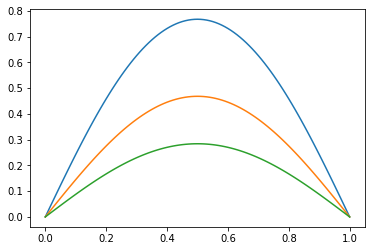

In [8]:
x = np.linspace(0, l, 101)
plt.figure()
t_diffusion = (1/np.pi**2)/(kappa/l**2)
print(t_diffusion/60, 'mins')
for t in np.linspace(0.5, 1.5, 3)*t_diffusion:
    sol = approx_sol_dim(u0, x, t, 10000, kappa, l)
    plt.plot(x, sol)
    print(sol.max(), sol.max()*(np.pi * np.e / 4))
plt.show()

In [70]:
import openpnm as op
wrk = op.Workspace()
#wrk.settings['loglevel'] = 20
spacing = 1e-2
net = op.network.Cubic(shape=[101, 1, 1], spacing=spacing)
# translate to origin
net['pore.coords'] -= np.array([spacing, spacing, spacing])/2

In [71]:
l = net['pore.coords'][:, 0].max() - net['pore.coords'][:, 0].min()
print(l)

1.0000000000000002


In [72]:
geo = op.geometry.GenericGeometry(network=net, pores=net.Ps, throats=net.Ts)

In [73]:
geo['pore.diameter'] = spacing
geo['throat.diameter'] = spacing
geo['throat.length'] = spacing
geo['throat.area'] = spacing**2
geo['pore.area'] = spacing**2
geo['pore.volume'] = spacing**3
geo['throat.volume'] = 0.0

In [74]:
phase = op.phases.GenericPhase(network=net)
phase['pore.conductivity'] = kappa
phys = op.physics.GenericPhysics(network=net, geometry=geo, phase=phase)
c = 1.0  # mol/m^3
phys['throat.conductance'] = c*kappa*geo['throat.area']/geo['throat.length']

In [75]:
alg = op.algorithms.FourierConduction(network=net)
alg.setup(phase=phase, conductance='throat.conductance')
alg.set_value_BC(pores=[0], values=1.0)
alg.set_value_BC(pores=[-1], values=0.0)
alg.run()
K_eff = alg.calc_effective_conductivity(domain_length=l, domain_area=spacing**2)[0]
print(K_eff, kappa, np.allclose(K_eff, kappa))

0.00011595547309833424 0.00011595547309833024 True


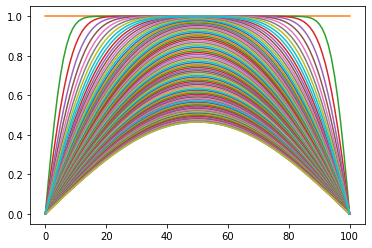

In [76]:
alg = op.algorithms.TransientReactiveTransport(network=net)
alg.setup(phase=phase, conductance='throat.conductance', quantity='pore.temperature',
          t_initial=0, t_final=880, t_step=0.1, t_output=10,
          t_tolerance=1e-12, t_precision=12, rxn_tolerance=1e-12, t_scheme='implicit')
alg.set_IC(values=u0)
alg.set_value_BC(pores=[0], values=0.0)
alg.set_value_BC(pores=[-1], values=0.0)
alg.run()
res = alg.results()
times = list(res.keys())
times.sort()
plt.figure()
for time in times:
    plt.plot(alg[time])

In [77]:
t_diffusion

873.793887731521

In [78]:
'pore.temperature@870' in times

True

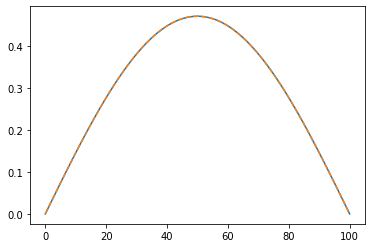

2.6050511969355483e-05


In [79]:
plt.figure()
x = net['pore.coords'][:, 0]
a = alg['pore.temperature@870']
b = approx_sol_dim(u0, x, 870.0, 10000, kappa, l)
plt.plot(a)
plt.plot(b, '--')
plt.show()
print(np.max(a-b))

In [82]:
def approx_sol_inhom(u1, x, t, N):
    out = 0
    for i in range(N):
        n = i+1
        out += ((-1)**n)/n * np.sin(n*np.pi*x) * np.exp(-n**2 * np.pi**2 * t)
    return u1*x + (2*u1/np.pi)*out

<function matplotlib.pyplot.show(*args, **kw)>

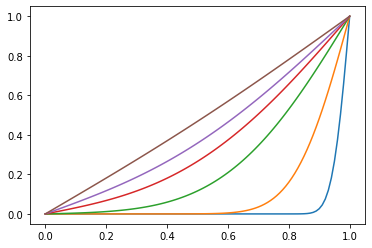

In [90]:
u1 = 1.0
x = np.linspace(0, 1, 101)
plt.figure()
for t in np.array([0.01, 0.1, 0.5, 1.0, 1.5, 3])/np.pi**2:
    sol = approx_sol_inhom(u1, x, t, N=10000)
    plt.plot(x, sol)
plt.show

In [87]:
def approx_sol_inhom_dim(u1, x, t, N, kappa, l):
    out = 0
    for i in range(N):
        n = i+1
        out += ((-1)**n)/n * np.sin(n*np.pi*x/l) * np.exp(-n**2 * np.pi**2 * t * kappa/l**2)
    return u1*x/l + (2*u1/np.pi)*out

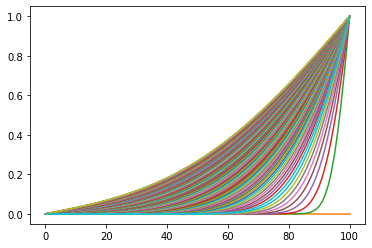

In [88]:
alg = op.algorithms.TransientReactiveTransport(network=net)
alg.setup(phase=phase, conductance='throat.conductance', quantity='pore.temperature',
          t_initial=0, t_final=880, t_step=0.1, t_output=10,
          t_tolerance=1e-12, t_precision=12, rxn_tolerance=1e-12, t_scheme='implicit')
alg.set_IC(values=0.0)
alg.set_value_BC(pores=[0], values=0.0)
alg.set_value_BC(pores=[-1], values=u1)
alg.run()
res = alg.results()
times = list(res.keys())
times.sort()
plt.figure()
for time in times:
    plt.plot(alg[time])

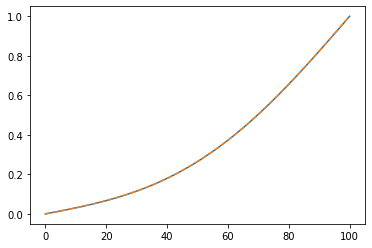

2.7843906285629494e-06


In [89]:
plt.figure()
x = net['pore.coords'][:, 0]
a = alg['pore.temperature@870']
b = approx_sol_inhom_dim(u0, x, 870.0, 10000, kappa, l)
plt.plot(a)
plt.plot(b, '--')
plt.show()
print(np.max(a-b))

Now consider a source term $sin(\pi x)$

$u_{t} = u_{xx} + sin(\pi x)$

subject to B.Cs

$u(0) = u(1) = 0$

In [92]:
def approx_sol_source(x, t):
    return (np.sin(np.pi*x)/(np.pi**2))*(1-np.exp(-np.pi**2 * t))

In [118]:
def approx_sol_source_dim(x, t, kappa, l):
    return (np.sin(np.pi*x/l)/(np.pi**2))*(1-np.exp(-np.pi**2 * t * kappa/l**2))

<function matplotlib.pyplot.show(*args, **kw)>

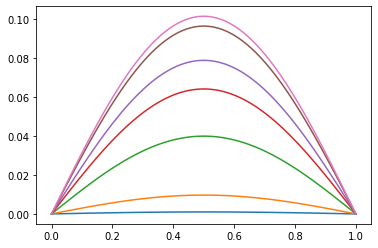

In [94]:
x = np.linspace(0, 1, 101)
plt.figure()
for t in np.array([0.01, 0.1, 0.5, 1.0, 1.5, 3, 100])/np.pi**2:
    sol = approx_sol_source(x, t)
    plt.plot(x, sol)
plt.show()

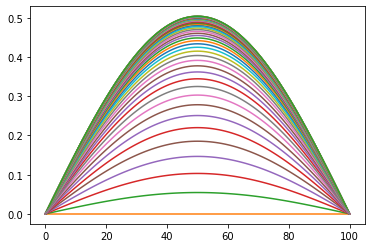

In [120]:
Qf = 2000*net['pore.volume']/(Cp*rho)
Q = Qf*np.sin(np.pi*x)
phys['pore.source.S1'] = 0.0
phys['pore.source.S2'] = Q
phys['pore.source.rate'] = Q

alg = op.algorithms.TransientReactiveTransport(network=net)
alg.setup(phase=phase, conductance='throat.conductance', quantity='pore.temperature',
          t_initial=0, t_final=10000, t_step=10.0, t_output=100,
          t_tolerance=1e-7, t_precision=12, rxn_tolerance=1e-7, t_scheme='implicit')
alg.set_IC(values=0.0)
alg.set_value_BC(pores=[0], values=0.0)
alg.set_value_BC(pores=[-1], values=0.0)
alg.set_source(propname='pore.source', pores=net.pores()[1:-1])
alg.run()
res = alg.results()
times = list(res.keys())
times.sort()
plt.figure()
for time in times:
    plt.plot(alg[time])

In [116]:
alg['pore.temperature@4530'].max()

0.503654976367577

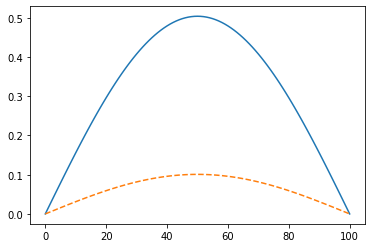

0.4029015885170053


In [119]:
plt.figure()
x = net['pore.coords'][:, 0]
a = alg['pore.temperature@4530']
b = approx_sol_source_dim(x, 4530.0, kappa, l)
plt.plot(a)
plt.plot(b, '--')
plt.show()
print(np.max(a-b))

In [127]:
def crazy_source(x, t, N):
    # https://www.math.upenn.edu/~deturck/m241/inhomogeneous.pdf
    out = 0
    for n in range(N):
        a = 4*((2*n+1)**2 * np.pi**2 - 2)*np.exp(-(2*n+1)**2 * np.pi**2 * t)/((2*n+1)**3 * np.pi**3 * ((2*n+1)**2 *np.pi**2 - 1))
        b = 4*np.exp(-t)/((2*n+1)*np.pi*((2*n+1)**2*np.pi**2-1))
        c = np.sin((2*n+1)*np.pi*x)
        out += (a+b)*c
    return out

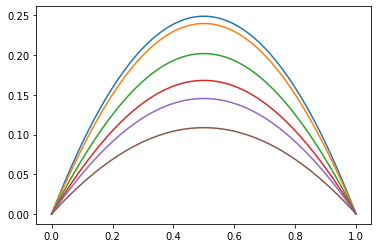

In [131]:
x = np.linspace(0, 1, 101)
plt.figure()
times = np.array([0.01, 0.1, 0.5, 1.0, 1.5, 3])/np.pi**2
for t in times:
    sol = crazy_source(x, t, 10000)
    plt.plot(x, sol)
plt.show()

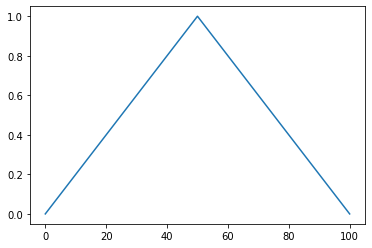

In [149]:
plt.figure()
x = np.linspace(0, 2, 101)
plt.plot(1-np.abs(x-1))

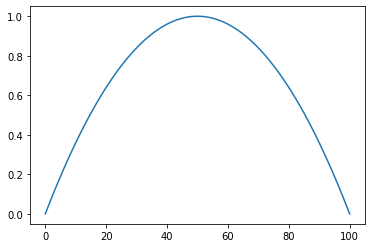

In [150]:
plt.figure()
plt.plot(2*x-x**2)

In [162]:
def qn(n, x):
    return (8/(n**2 * np.pi**2))*np.sin(n*np.pi*x/2)
def an(n, x):
    return (4/(n**2 * np.pi**2))*qn(n, x)
def cn(n):
    return (16/(n**3 * np.pi**3))*(1-np.cos(n*np.pi))
def bn(n, x):
    return cn(n) - an(n, x)
def approx_sol_sawtooth(x, t, N):
    #https://faculty.uca.edu/darrigo/Students/M4315/Fall%202005/sep-var.pdf
    out = 0
    for i in range(N):
        n = i+1
        np2 = (n*np.pi/2)
        e = np.exp(-((np2**2) * t))
        out += ( an(n, x) + bn(n, x) * e ) * np.sin(np2*x)
    
    return out

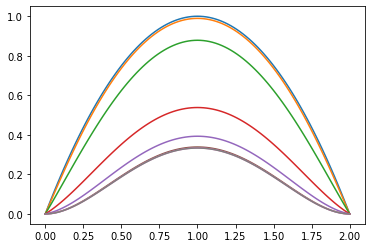

In [164]:
for t in [0.0, 0.01, 0.1, 0.5, 1.0, 2.0, 3.0, 100.0]:
    sol = approx_sol_sawtooth(x, t, 10000)
    plt.plot(x, sol)
plt.show()